# Plotting with Pandas
The `plot()` method is available on `Series` and `DataFrame` objects. Many of the parameters get passed down to matplotlib. The `kind` argument let's us vary the plot type.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fb = pd.read_csv(
    'data/fb_stock_prices.csv', index_col='Date', parse_dates=True
)
quakes = pd.read_csv('data/earthquakes.csv')

## Evolutions over time
Line graphs help us see how a variable changes over time. They are the default for the `kind` argument, but we can pass `kind='line'` to be explicit in our intent:

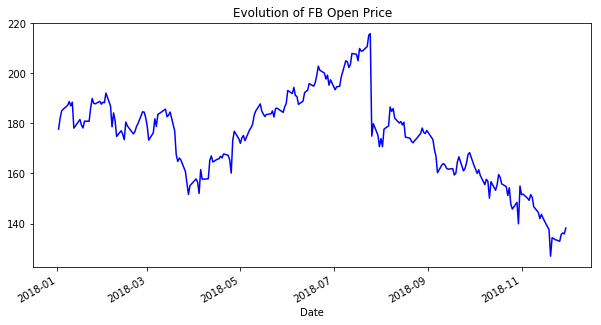

In [2]:
fb.plot(
    kind='line',
    y='Open',
    figsize=(10, 5),
    style='b-',
    legend=False,
    title='Evolution of FB Open Price'
)

We provided the `style` argument in the previous example; however, we can use the `color` and `linestyle` arguments to get the same result:

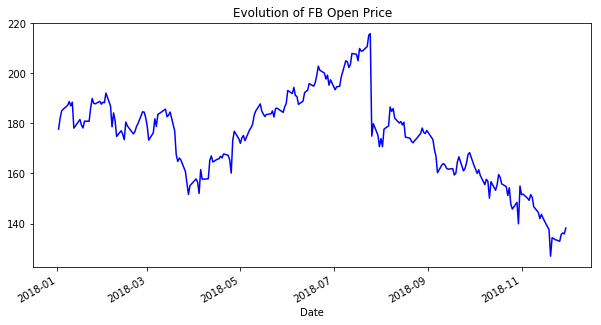

In [3]:
fb.plot(
    kind='line',
    y='Open',
    figsize=(10, 5),
    color='blue',
    linestyle='solid',
    legend=False,
    title='Evolution of FB Open Price'
)

We can also plot many lines at once by simply passing a list of the columns to plot:

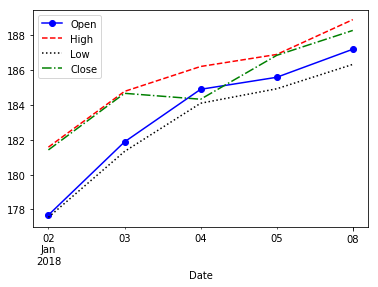

In [4]:
fb.iloc[:5,].plot(
    y=['Open', 'High', 'Low', 'Close'],
    style=['b-o', 'r--', 'k:', 'g-.']
)

## Creating subplots
When plotting with pandas, creating subplots is simply a matter of passing `subplots=True` to the `plot()` method, and (optionally) specifying the `layout` in a tuple of `(rows, columns)`:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11DD9C90>,
      dtype=object)

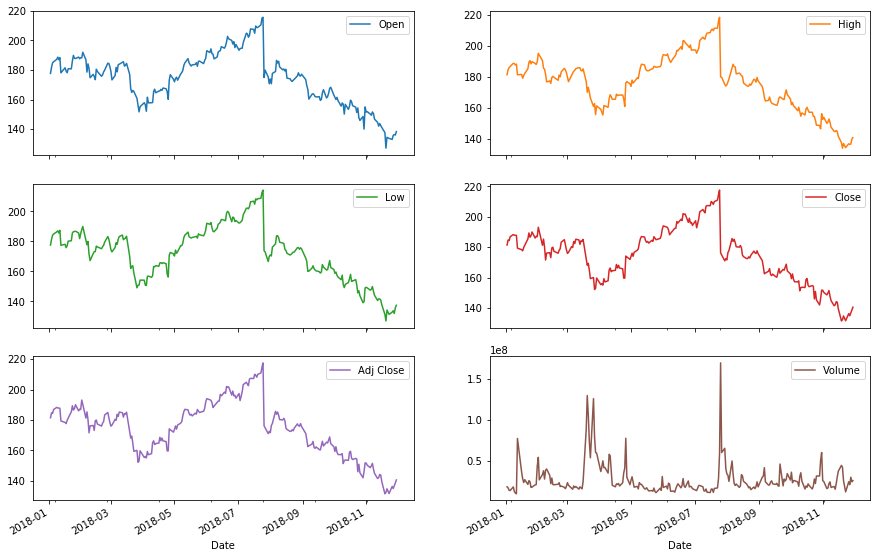

In [5]:
fb.plot(
    kind='line',
    subplots=True,
    layout=(3,2),
    figsize=(15,10)
)

Note that we didn't provide a specific column to plot and pandas plotted all of them for us.

## Visualizing relationships between variables
### Scatter plots
We make scatter plots to help visualize the relationship between two variables. Creating scatter plots requires we pass in `kind='scatter'` along with a column for the x-axis and a column for the y-axis:

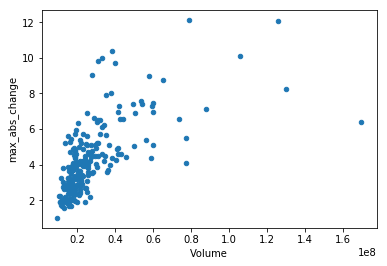

In [6]:
fb.assign(
    max_abs_change=fb.High - fb.Low
).plot(kind='scatter', x='Volume', y='max_abs_change')

The relationship doesn't seem to be linear, but we can try a log transform on the x-axis since the scales of the axes are very different. With pandas, we simply pass in `logx=True`:

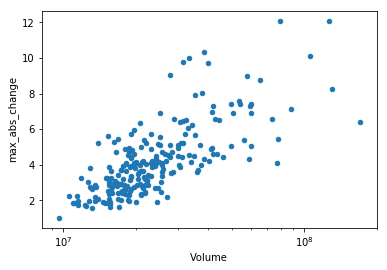

In [7]:
fb.assign(
    max_abs_change=fb.High - fb.Low
).plot(kind='scatter', x='Volume', y='max_abs_change', logx=True)

With matplotlib, we could use `plt.xscale('log')` to do the same thing.

### Adding Transparency to Plots with `alpha`
Sometimes our plots have many overlapping values, but this can be impossible to see. This can be addressed by increasing the transparency of what we are plotting using the `alpha` parameter. It is a float on [0, 1] where 0 is completely transparent and 1 is completely opaque. By default this is 1, so let's put in a lower value and re-plot the scatter plot:

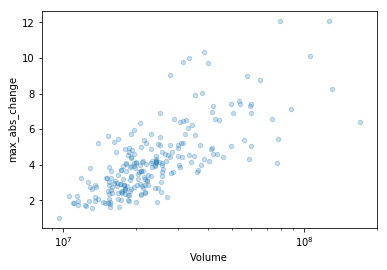

In [8]:
fb.assign(
    max_abs_change=fb.High - fb.Low
).plot(
    kind='scatter',
    x='Volume',
    y='max_abs_change',
    logx=True,
    alpha=0.25
)

### Hexbins
In the previous example, we can start to see the overlaps, but it is still difficult. Hexbins are another plot type that divide up the plot into hexagons, which are shaded according to the density of points there. With pandas, this is the `hexbin` value for the `kind` argument. It can also be important to tweak the `gridsize`, which determines the number of hexagons along the y-axis:

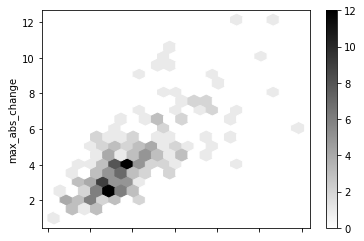

In [9]:
fb.assign(
    volume=np.log(fb.Volume),
    max_abs_change=fb.High - fb.Low
).plot(
    kind='hexbin',
    x='volume',
    y='max_abs_change',
    colormap='gray_r',
    gridsize=20
)

### Visualizing Correlations with Heatmaps
Pandas doesn't offer heatmaps; however, if we are able to get our data into a matrix, we can use `matshow()` from matplotlib:

[Text(0, 0, ''),
 Text(0, 0, 'open'),
 Text(0, 0, 'high'),
 Text(0, 0, 'low'),
 Text(0, 0, 'close'),
 Text(0, 0, 'adj close'),
 Text(0, 0, 'volume'),
 Text(0, 0, 'log_volume'),
 Text(0, 0, 'max_abs_change')]

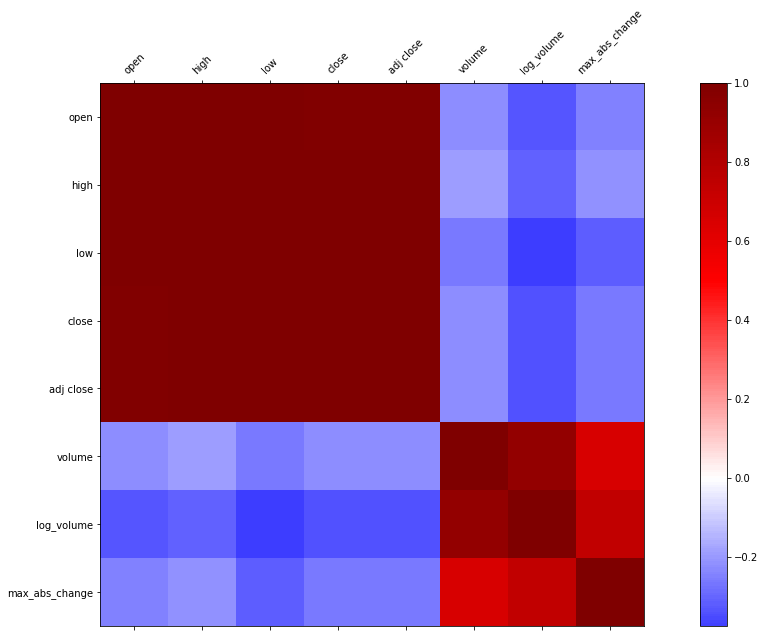

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))

fb_corr = fb.assign(
    log_volume=np.log(fb.Volume),
    max_abs_change=fb.High - fb.Low
).corr()

im = ax.matshow(fb_corr, cmap='seismic')
fig.colorbar(im).set_clim(-1, 1)

labels = [col.lower() for col in fb_corr.columns]
ax.set_xticklabels([''] + labels, rotation=45)
ax.set_yticklabels([''] + labels)

## Visualizing distributions
### Histograms
With the pandas `plot()` method, making histograms is as easy as passing in `kind='hist'`:

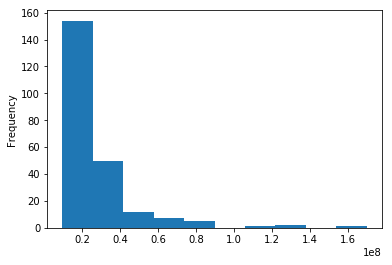

In [11]:
fb.Volume.plot(kind='hist')

### Kernel Density Estimation (KDE)
We can pass `kind='kde'` for a probability density function (PDF), which tells us the probability of getting a particular value:

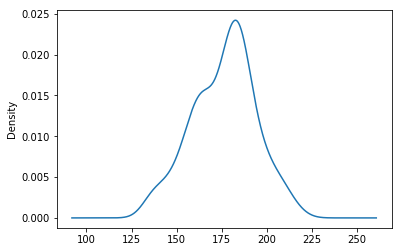

In [12]:
fb.High.plot(kind='kde')

### Adding to the result of `plot()`
The `plot()` method returns a matplotlib `Axes` object. We can store this for additional customization of the plot, or we can pass this into another call to `plot()` as the `ax` argument to add to the original plot. 

It can often be helpful to view the KDE superimposed on top of the histogram, which can be achieved with this strategy:

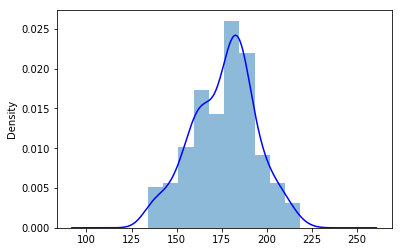

In [13]:
ax = fb.High.plot(kind='hist', density=True, alpha=0.5)
fb.High.plot(ax=ax, kind='kde', color='blue')

### Plotting the ECDF
In some cases, we are more interested in the probability of getting less than or equal to that value (or greater than or equal), which we can see with the cumulative disribution function (CDF). Using the `statsmodels` package, we can estimate the CDF giving us the empirical cumulative distribution function (ECDF):

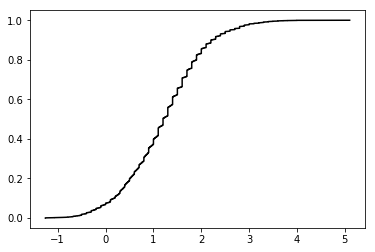

In [14]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(quakes.query('magType == "ml"').mag)
plt.plot(ecdf.x, ecdf.y, 'k-')

### Box plots
To make box plots with pandas, we pass `kind='box'` to the `plot()` method:

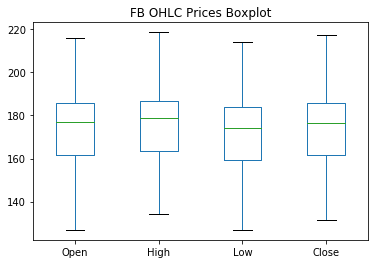

In [15]:
fb.iloc[:,:4].plot(kind='box', title='FB OHLC Prices Boxplot')

This can also be combined with a `groupby()`:

low          AxesSubplot(0.1,0.15;0.235294x0.75)
med     AxesSubplot(0.382353,0.15;0.235294x0.75)
high    AxesSubplot(0.664706,0.15;0.235294x0.75)
dtype: object

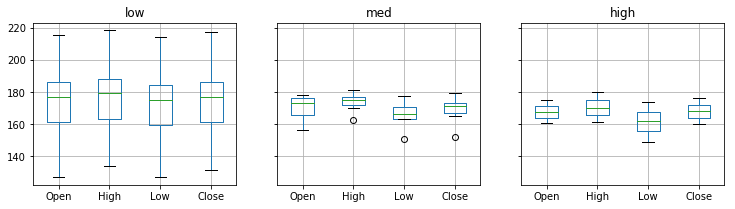

In [16]:
fb.assign(
    volume_bin=pd.cut(fb.Volume, 3, labels=['low', 'med', 'high'])
).groupby('volume_bin').boxplot(
    column=['Open', 'High', 'Low', 'Close'],
    layout=(1, 3),
    figsize=(12, 3)
)

We can use this to see the distribution of magnitudes across the different measurement methods for earthquakes:

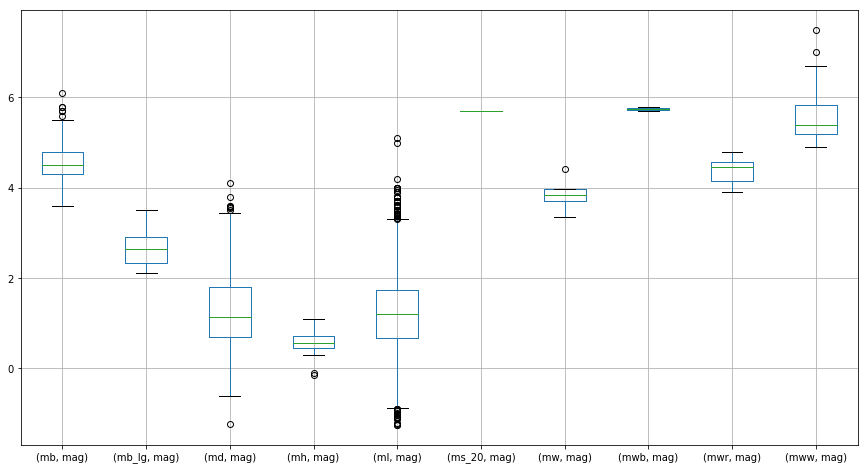

In [17]:
quakes[['mag', 'magType']].groupby('magType').boxplot(
    figsize=(15, 8), subplots=False
)

## Counts and frequencies
### Bar charts
With pandas, we have the option of using the `kind` argument or using `plot.<kind>()`. Let's use `plot.bar()` here:

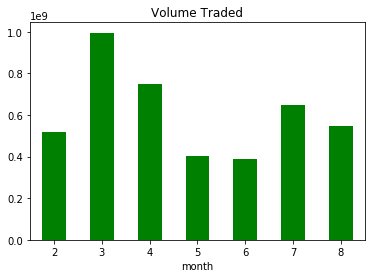

In [18]:
fb['2018-02':'2018-08'].assign(
    month=lambda x: x.index.month
).groupby('month').sum().Volume.plot.bar(
    color='green', rot=0, title='Volume Traded'
)

We can also change the orientation of the bars. Passing `kind='barh'` gives us horizontal bars instead of vertical ones:

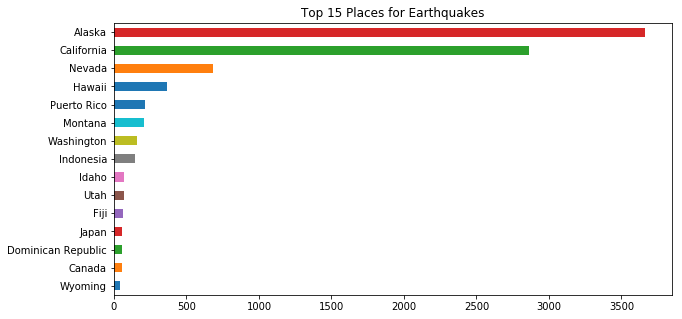

In [19]:
quakes.parsed_place.value_counts().iloc[14::-1,].plot(
    kind='barh', figsize=(10, 5), title='Top 15 Places for Earthquakes'
)

Using the `kind` arugment for vertical bars when the labels for each bar are shorter:

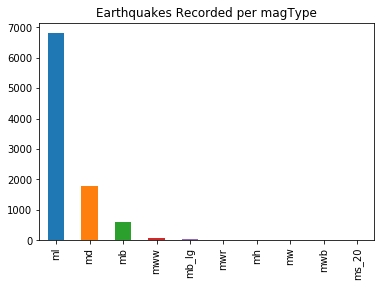

In [20]:
quakes.magType.value_counts().plot(
    kind='bar', title='Earthquakes Recorded per magType'
)

Top 4 places with earthquakes:

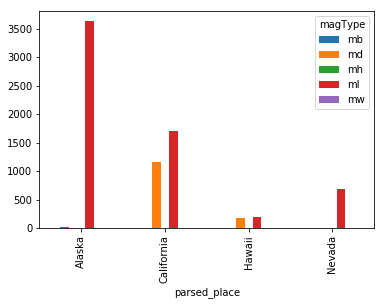

In [21]:
quakes[
    quakes.parsed_place.isin(['California', 'Alaska', 'Nevada', 'Hawaii'])
].groupby(['parsed_place', 'magType']).mag.count().unstack().plot.bar()

### Stacked bar chart

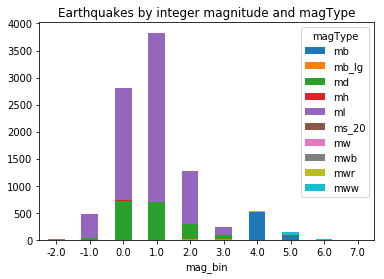

In [22]:
pivot = quakes.assign(
    mag_bin=lambda x: np.floor(x.mag)
).pivot_table(
    index='mag_bin', columns='magType', values='mag', aggfunc='count'
)
pivot.plot.bar(
    stacked=True, rot=0, 
    title='Earthquakes by integer magnitude and magType'
)

#### Normalized stacked bars

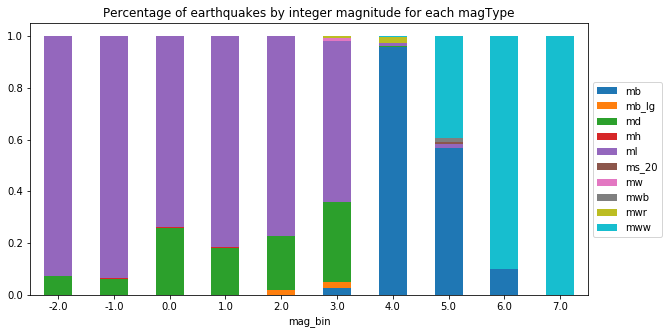

In [23]:
normalized_pivot = pivot.fillna(0).apply(lambda x: x/x.sum(), axis=1)
ax = normalized_pivot.plot.bar(
    stacked=True, rot=0, figsize=(10, 5),
    title='Percentage of earthquakes by integer magnitude for each magType'
)
ax.legend(bbox_to_anchor=(1, 0.8))